<a href="https://colab.research.google.com/github/QoutiOussama13/InsurAI/blob/main/Reporting_claims_Demo_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the Agent with Langchain 🦜🔗![accident1jpg.jpg](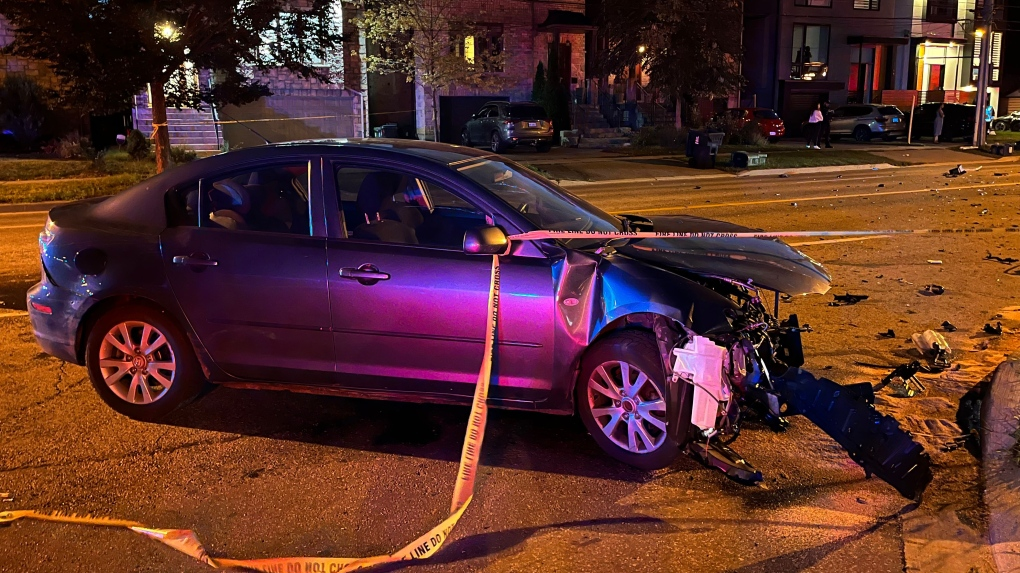![accident1jpg.jpg](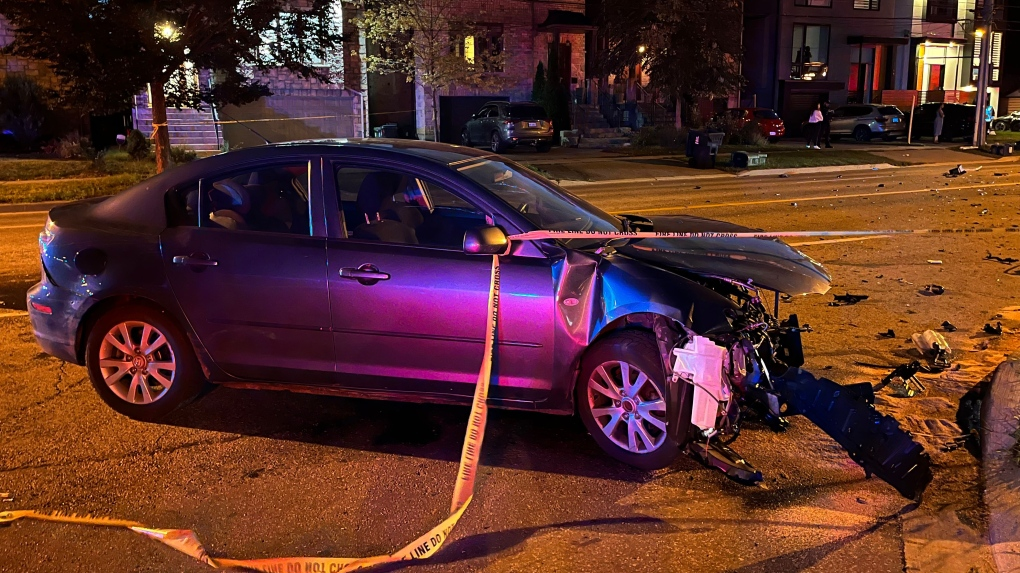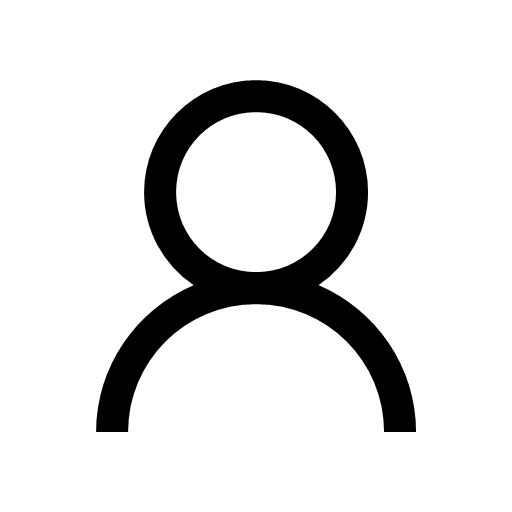)) and Evaluationg with TruLens 🦑

In [ ]:
! pip install langchain_community langchain-openai langchainhub chromadb langchain tavily-python

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
import json
import operator
from typing import Annotated, Sequence, TypedDict,Dict,Tuple
from langchain.prompts import PromptTemplate,ChatPromptTemplate,MessagesPlaceholder
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent, Tool,AgentExecutor
from langchain_community.tools.tavily_search import TavilySearchResults

Setting the OpenAI and Tavily keys

In [5]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [6]:
embeddings = OpenAIEmbeddings()

In [7]:
urls = [
    "https://en.wikipedia.org/wiki/Vehicle_insurance_in_the_United_States", #used this article for the prototype , will include more ressources in future versions
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

## making the chain tool

In [9]:
class Config():
    """
    Contains the configuration of the LLM.
    """
    model = 'gpt-4'
    llm = ChatOpenAI(temperature=0, model=model)

retrieval qa chain


In [13]:
cfg = Config()
qa = RetrievalQA.from_chain_type(
    llm=cfg.llm,
    chain_type="stuff",
    retriever = vectorstore.as_retriever()
)

Setting up the memroy for the agent

In [11]:
def setup_memory() -> Tuple[Dict, ConversationBufferMemory]:
    """
    Sets up memory for the  agent.
    :return a tuple with the agent keyword pairs and the conversation memory.
    """
    agent_kwargs = {
        "extra_prompt_messages": [MessagesPlaceholder(variable_name="memory")],
    }
    memory = ConversationBufferMemory(memory_key="memory", return_messages=True)
    return agent_kwargs, memory

making our agent

In [16]:
def setup_agent() -> AgentExecutor:
    """
    Sets up the tools for a function based chain.
    We have here the following tools:

    """
    cfg = Config()
    tools = [
        Tool(
            name="knowledge search",
            func=qa.run,
            description="useful for when you need information about questions about insurence. "
        ),
        Tool(
        name='web search',
        func=TavilySearchResults().run,
        description=(
            '''use this tool when you can't find the content in the knowledge base and you need more advenced search functionalities  '''
        ))

    ]
    agent_kwargs, memory = setup_memory()

    return initialize_agent(
        tools,
        cfg.llm,
        verbose=False,
        agent_kwargs=agent_kwargs,
        memory=memory
    )

This the agent where you perform all the interactions , it got chat memroy , output and other useful things

In [17]:
agent_executor = setup_agent()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


In [18]:
agent_executor.memory.buffer

[]

In [19]:
template="""You are insurAI an expert in assitant used by top insurence companies your main role is to help the clients in their accident .
you can answer anyhting else and you answers should always be helpful and provide assitant for the users
start by doing checking the images the user provided
remember to give helpful advices then keep ask follow up questions to the users until you have a clear understanding of the problem they are having
you can also estimate how much their insurence will give them back based on the damage of the car and the situation
You have access to the following tools:
\n\nknowledge search: useful for when you need information about questions about insurance.
\nweb search: use this tool when you can't find the content in the knowledge base and you need more advanced search functionalities
\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [knowledge search, web search]\n
Action Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\n
Thought: I now know the final answer\n
Final Answer: the final answer to the original input question\n\nBegin!\n\n
Question: {input}\nThought:{agent_scratchpad}"""


In [20]:
promptup = PromptTemplate(
    input_variables=['agent_scratchpad', 'input'],
    template = template
)


In [22]:
promptup.pretty_print()

You are insurAI an expert in assitant used by top insurence companies your main role is to help the clients in their accident .
you can answer anyhting else and you answers should always be helpful and provide assitant for the users
start by doing checking the images the user provided 
remember to give helpful advices then keep ask follow up questions to the users until you have a clear understanding of the problem they are having 
you can also estimate how much their insurence will give them back based on the damage of the car and the situation 
You have access to the following tools:


knowledge search: useful for when you need information about questions about insurance. 

web search: use this tool when you can't find the content in the knowledge base and you need more advanced search functionalities


Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [knowledge searc

In [23]:
agent_executor.agent.llm_chain.prompt = promptup

Building the image captioning with **GPt4-V**

In [26]:
import base64
import requests

def generate_caption(api_key, image_path):
    # Function to encode the image
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    # Getting the base64 string
    base64_image = encode_image(image_path)

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Please describe this image as good and authentic as possible , include all it details possible as it will be fed to and auto claim system to insurence companies"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    return response.json()['choices'][0]['message']['content']

# Example usage:
api_key = os.environ['OPENAI_API_KEY']
image_path = "/content/accident1jpg.jpg"
caption = generate_caption(api_key, image_path)
caption


'The image depicts a nighttime scene of a car accident. The vehicle is a four-door sedan with a dark, possibly blue or purple color, reflecting the ambient light around it. The car has sustained major damage to its front right quadrant.\n\nSpecifically, the front right corner of the car is severely crumpled, indicating a high-impact collision. The hood is bent upwards, and the right headlight assembly is completely shattered, with fragments of the light strewn across the road. The front bumper is detached on the right side and hanging off, exposing the internal components such as the radiator, which also appears to be damaged.\n\nThe right front wheel assembly is partially dislodged from the axle, suggesting a significant force was applied during the impact. Underneath the car, more debris can be seen, which looks like parts of the car\'s undercarriage.\n\nFurthermore, the airbags have deployed inside the vehicle, visible through the front windshield. The rear of the car seems intact. 

In [27]:
a = agent_executor.invoke(caption + 'I had this terrible accident, tell me what I can do?')

In [28]:
a['output']

"I'm sorry to hear about your accident. Here are some steps you should take:\n\n1. Check yourself and any passengers for injuries. If anyone is injured, call 911 immediately.\n2. If it's safe to do so, move your car out of the way of traffic.\n3. Contact the police to report the accident.\n4. Document the accident as much as possible. Take pictures of the damage and the scene, and write down what happened while it's fresh in your mind.\n5. Exchange information with the other driver involved in the accident.\n6. Contact your insurance company as soon as possible to report the accident and start the claim process.\n\nWhen filing a claim, you'll need to provide your insurance company with information about the accident, including the date, location, and details of what happened. You'll also need to provide information about the other driver if another vehicle was involved. Your insurance company will then assign a claims adjuster to investigate the claim and determine how much the insuran

using TruLens 🦑 to evaluate the performence of the QA (we used only the qa chain for the evaluation and we will include more advanced evaluationg in the future )

In [ ]:
!pip install trulens_eval

In [39]:
from trulens_eval.feedback.provider import OpenAI
import numpy as np
from trulens_eval import TruChain, Feedback, Tru

tru = Tru()
tru.reset_database()


openai = OpenAI()

from trulens_eval.app import App
context = App.select_context(qa)

from trulens_eval.feedback import Groundedness
grounded = Groundedness(groundedness_provider=OpenAI())
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons)
    .on(context.collect())
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

f_qa_relevance = Feedback(openai.relevance).on_input_output()
f_context_relevance = (
    Feedback(openai.qs_relevance)
    .on_input()
    .on(context)
    .aggregate(np.mean)
)

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.
✅ In groundedness_measure_with_cot_reasons, input source will be set to __record__.app.retriever.get_relevant_documents.rets.collect() .
✅ In groundedness_measure_with_cot_reasons, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In qs_relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In qs_relevance, input statement will be set to __record__.app.retriever.get_relevant_documents.rets .


In [40]:
tru_recorder = TruChain(qa,
    app_id='ChatApp',
    feedbacks=[f_qa_relevance, f_context_relevance, f_groundedness])

In [41]:
with tru_recorder as recording:
    llm_response = qa.run(caption + 'I had this terrible accident, tell me what I can do?')
display(llm_response)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


"Based on the information provided, here are some steps you can take:\n\n1. Contact your insurance company: Report the accident to your insurance company as soon as possible. They will guide you through the process of filing a claim. \n\n2. Collision coverage: If you have collision coverage, it should cover the damage to your vehicle, subject to your deductible. This coverage is designed to provide payments to repair the damaged vehicle, or payment of the cash value of the vehicle if it is not repairable or totaled.\n\n3. Comprehensive coverage: If the accident was caused by factors other than collision (like weather, vandalism, etc.), and you have comprehensive coverage, it should cover the damage to your vehicle, subject to your deductible.\n\n4. Legal advice: Depending on the circumstances of the accident, you may want to consult with a lawyer, especially if there were injuries involved or if you're unsure about your insurance coverage.\n\n5. Document everything: Take pictures of th

In [42]:
rec = recording.get()

In [43]:
for feedback, feedback_result in rec.wait_for_feedback_results().items():
    print(feedback.name, feedback_result.result)

relevance 0.8
qs_relevance 0.2
groundedness_measure_with_cot_reasons 0.2857142857142857


In [44]:
tru.get_leaderboard(app_ids=["ChatApp"])

,relevance,groundedness_measure_with_cot_reasons,qs_relevance,latency,total_cost
app_id,,,,,
ChatApp,0.8,0.285714,0.2,12.0,0.0486


In [112]:
a = agent_executor.invoke('some guy just hit my car from the back in the red light , it is severly damaged what I should do? ')

In [45]:
tru.run_dashboard()

Starting dashboard ...
npx: installed 22 in 3.984s

Go to this url and submit the ip given here. your url is: https://cute-times-try.loca.lt

  Submit this IP Address: 34.106.132.124



<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [153]:
tru.stop_dashboard()

Dashboard closed.
Dashboard closed.
